<a href="https://colab.research.google.com/github/andreianmatos/temporal_spaces_texture_gen/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright: [Tensorflow's DCGAN tutorial](https://www.tensorflow.org/tutorials/generative/dcgan?hl=en) and [Tensorflow's CVAE tutorial](https://www.tensorflow.org/tutorials/generative/cvae?hl=en)


Training the movement's textures on:

- Deep Convolutional Generative Adversarial Network
- Convolutional Variational Autoencoder

# Setup

In [1]:
!pip install tensorflow-probability
!pip install tensorflow-docs

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import time
from IPython import display
import requests
from io import BytesIO
from zipfile import ZipFile
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow_docs.vis.embed as embed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 4.2 MB/s eta 0:00:00
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_h331nm2
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-_h331nm2
  Resolved https://github.com/tensorflow/docs to commit d13c500b2e552ce04095287a99c575d2685a2160
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.1.17.4828-py3-none-any.whl size=181243 sha256=26e64d2d8ae7dea91fe19bcb04b8eb15f58166f7c54947b2dfbbd0d7fdd2417e
  Stored in directory: /tmp/pip-ephem-wheel-cache-hnzqoj1x/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs
  Attempting uninstall: tensorflow-docs
    Found existing installation: tensorflow-docs 2023.5.24.56664
    Uninstalling tensorflow-docs-2023.5.24.56664:
      Successfully uninstalled tensorflow-docs-2023.5.24.56664


In [2]:
tf.__version__

'2.15.0'

In [3]:
# Create the directories
dcgan_directory_path = os.path.join('DCGAN')
os.makedirs(dcgan_directory_path, exist_ok=True)

cvae_directory_path = os.path.join('CVAE')
os.makedirs(cvae_directory_path, exist_ok=True)

# Load and Prepare the Dataset

We will use the [movement's texture](https://github.com/andreianmatos/temporal_spaces_texture_gen/tree/main/datasets) dataset.

In [4]:
dataset_link = 'https://github.com/andreianmatos/temporal_spaces_texture_gen/raw/main/datasets/captures.zip'

# Fetch the zip file content
response = requests.get(dataset_link)
zip_data = BytesIO(response.content)

# Extract the contents of the zip file
with ZipFile(zip_data, 'r') as zip_ref:
    zip_ref.extractall()

dataset_path = 'captures'

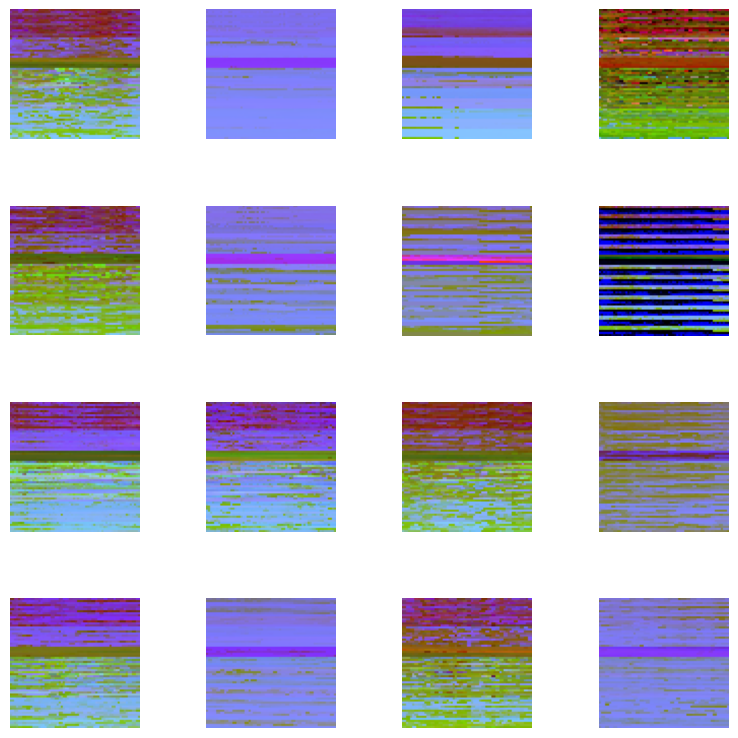

In [5]:
# Define the path to your dataset
image_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith('.png')]

images = []
# Loop through each image file and load the image
for image_file in image_files:
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize the image to your desired size
    # image = cv2.resize(image, (28, 28))
    # Normalize pixel values to the range [0, 1] and save as float32
    image = image.astype(np.float32) / 255.0
    images.append(image)

train_images = np.array(images, dtype=np.float32)

np.save('preprocessed_train_images.npy', train_images)

# Display images in a grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(train_images[i * 4 + j])
        axs[i, j].axis('off')

plt.show()

# Deep Convolutional Generative Adversarial Network

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* learns to create images that look real, while a *discriminator* learns to tell real images apart from fakes.

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

The images begin as random noise, and increasingly resemble the original textures over training.

![sample output](https://github.com/andreianmatos/temporal_spaces_texture_gen/blob/main/results/dcgan_gif.gif?raw=true)

### Dataset Preprocessing

In [6]:
os.chdir(dcgan_directory_path)
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Current working directory: /content/DCGAN


In [7]:
BUFFER_SIZE = 990 # roughly dataset size
BATCH_SIZE = 16

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()

    # Input layer for random noise
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape to 8x8x256
    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    # Conv2DTranspose layer with 128 filters, kernel size (5, 5), strides (2, 2)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose layer with 64 filters, kernel size (5, 5), strides (2, 2)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Conv2DTranspose layer with 3 filters (for RGB), kernel size (5, 5), strides (2, 2)
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) #sigmoid?
    assert model.output_shape == (None, 64, 64, 3)

    return model

Use the (as yet untrained) generator to create an image.

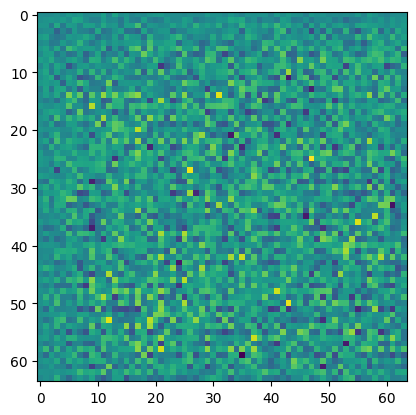

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

### The Discriminator

The discriminator is a CNN-based image classifier.

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0021992]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [17]:
EPOCHS = 1500
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [18]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    #return gen_loss, disc_loss

In [19]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Calculate and print generator and discriminator losses
        # gen_loss, disc_loss = get_epoch_losses(dataset)
        # print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

def get_epoch_losses(dataset):
    # Calculate average generator and discriminator losses for the epoch
    total_gen_loss = 0
    total_disc_loss = 0
    num_batches = 0

    for image_batch in dataset:
        gen_loss, disc_loss = train_step(image_batch)
        total_gen_loss += gen_loss
        total_disc_loss += disc_loss
        num_batches += 1

    avg_gen_loss = total_gen_loss / num_batches
    avg_disc_loss = total_disc_loss / num_batches

    return avg_gen_loss, avg_disc_loss


**Generate and save images**


In [20]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        # Rescale values from [-1, 1] to [0, 1]
        image = (predictions[i, :, :, :] + 1.0) / 2.0
        plt.imshow(image)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

def generate_image(model, test_input):
    predictions = model(test_input, training=False)
    for i in range(predictions.shape[0]):
        predictions = model(test_input, training=False)
        image = (predictions[j, :, :, :] + 1.0) / 2.0
        image = np.array(image * 255, dtype=np.uint8)
        image = Image.fromarray(image)
        return image

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated textures will look increasingly like the training textures...

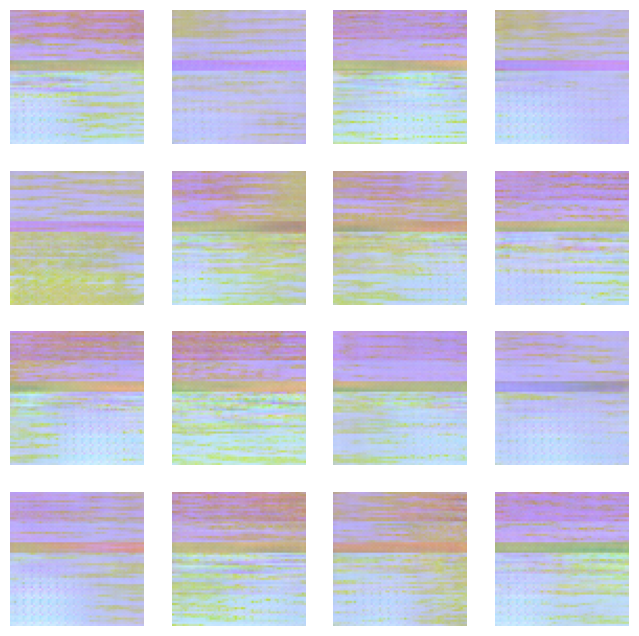

In [21]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [32]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [23]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

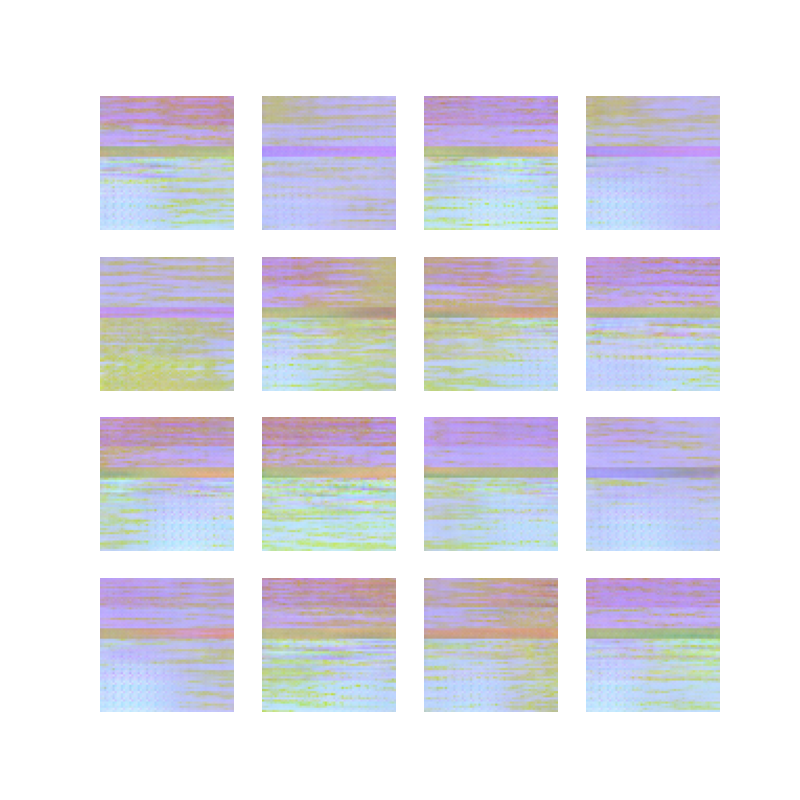

In [24]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [25]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-25-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-25-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [26]:
embed.embed_file(anim_file)

## Generate Images

Create image generation loop...

In [33]:
if not os.path.exists('generated_images2'):
  os.makedirs('generated_images2')
os.chdir('generated_images2')

nr_images_to_generate = 10
generated_images = []
for i in range(nr_images_to_generate):
  seed = tf.random.normal([num_examples_to_generate, noise_dim])
  image = generate_image(generator, test_input=seed)
  image.save('image_{:d}.png'.format(i))
  generated_images.append(image)

plt.figure(figsize=(15, 3))
for i in range(nr_images_to_generate):
    plt.subplot(1, nr_images_to_generate, i+1)
    plt.imshow(generated_images[i])
    plt.axis('off')

plt.show()
os.chdir('..')

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 3 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/